In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.
/Users/hayashikentaro/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/hayashikentaro/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/hayashikentaro/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 =

In [3]:
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(y_train.shape)
print(y_test.shape)
print(X_train[0].dtype) # uint8
# print(X_train[0])

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)
uint8


In [4]:
X_train = X_train.reshape(-1 , 784)
X_test = X_test.reshape(-1 , 784)
print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


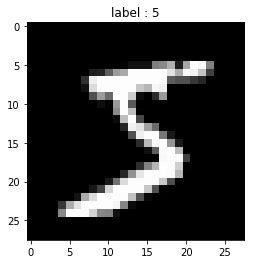

In [5]:
index = 0
image = X_train[index].reshape(28,28)
plt.imshow(image , "gray")
plt.title("label : {}".format(y_train[index]))
plt.show()

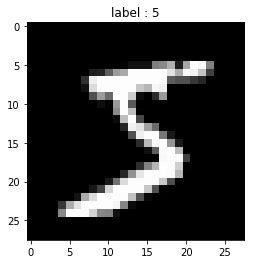

(28, 28)


In [6]:
index = 0
image = X_train[index].reshape(28,28)
image = image.astype(np.float)#float型に変換
image -= 105.35 #意図的に負の小数値を作り出してみる
plt.imshow(image , "gray")
plt.title("label : {}".format(y_train[index]))
plt.show()
print(image.shape)

In [7]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max())#1.0
print(X_train.min())#0.0

1.0
0.0


In [8]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [9]:
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8

(60000, 784)
(10000, 784)
float64


In [10]:
from sklearn.model_selection import train_test_split
X_train , X_val , y_train , y_val = train_test_split(
             X_train , y_train_one_hot , test_size = 0.20)
print(X_train.shape)
print(X_val.shape)

(48000, 784)
(12000, 784)


In [11]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [12]:
get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)

for mini_X_train, mini_y_train in get_mini_batch:
    # このfor文内でミニバッチが使える
    pass

## 【問題1】チャンネル数を1に限定した1次元畳み込み層クラスの作成

In [13]:
class XavierInitializer():
    def __init__(self, filter_num,filter_size):
        self.n_nodes1 = filter_num
        self.n_nodes2 = filter_size        
    
    def W(self):
        sigma = np.sqrt(1.0 / 1.0)
        self.W = sigma * np.random.randn(self.filter_num, self.filter_size)
        return self.W
    
    def B(self):
        sigma = np.sqrt(1.0 / 1.0)
        self.B = sigma * np.random.randn(self.filter_num)
        return self.B

In [14]:
class AdaGrad():
    def __init__(self , lr):
        self.lr = lr
        self.hw = None
        self.hb = None
    
    def update(self , layer):
#         layer.W = self.W
#         layer.B = self.B
#         layer.dW = self.dW
#         layer.dB = self.dB
        
        layer.hw += (layer.dW) * (layer.dW)
        layer.W -= self.lr * (layer.dW) / (np.sqrt(layer.hw) + 1e-7)
        layer.hb += (layer.dB) * (layer.dB)
        layer.B -= self.lr * (layer.dB) / (np.sqrt(layer.hb) + 1e-7)
        self.hw = layer.hw
        self.hb = layer.hb
        return layer.W, layer.B  

In [15]:
class SimpleConv1d():
    def __init__(self,filter_num,filter_size,lr = 0.01,initializer=XavierInitializer,optimizer=AdaGrad(lr = 0.01),stride=1,pad=0,sigma=0.01):
        self.optimizer = optimizer
        self.initializer = initializer
        self.filter_num = filter_num
        self.filter_size = filter_size
        self.stride = stride
        self.sigma = sigma
        self.pad = pad
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
#         self.W = self.initializer.W(self. filter_num, self.filter_size)
#         self.B = self.initializer.B(self.filter_num)
        self.W = np.array([3, 5, 7]).astype(np.float)
        self.B = np.array([1]).astype(np.float)
        self.A_list = []
        self.N_out = None
        self.dW_list = []
        self.dB_list = []
        (self.filter_num+2*self.pad-self.filter_size)//self.stride + 1
        self.lr = lr
        self.hw = 0
        self.hb = 0
        
    def forward(self, X):
        self.X = X
        self.n_iter =   int(self.X.shape[0] - self.W.shape[0]/self.stride + 1)
        self.X_index = np.arange(self.W.shape[0])
        for i in range(self.n_iter):
            self.A = np.dot(self.X[self.X_index+i] , self.W) + self.B
            self.A_list = np.append(self.A_list,self.A)
        return self.A_list
    def backward(self , dA):
        self.X_index2 = np.arange(dA.shape[0])
        self.n_iter2 = int(self.X.shape[0] - dA.shape[0]//self.stride + 1)
        for i in range(dA.shape[0]):
            self.dW_list = []
            self.dB_list = []
            self.dB = np.sum(dA)
            self.dB_list.append(self.dB)
            for k in range(self.n_iter2):
                self.dW = np.dot(self.X[self.X_index2+k].T , dA)
                self.dW_list.append(self.dW)     
            for j in range(self.filter_size-1):
#                 if j-self.stride < 0 or j-self.stride > self.N_out-1:
                dZ=np.zeros(self.X.shape[0])
                for i in range(dA.shape[0]):
                    dZ[i:i+self.filter_size]+=self.W*dA[i]

        # 更新
        print(self.dB_list)
        print(self.dW_list)
        self = self.optimizer.update(self)
        return dZ
    
        def N_out(self):
            return  (self.filter_num[1]+2*self.pad-self.filter_size[2])//self.stride + 1

In [16]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, *shape):
        """
        重みの初期化
        Parameters
        ----------

        Returns
        ----------
        W : (n_nodes1, n_nodes2,)
        W : (n_in_channels, n_out_channels, filter_size,)
        """
        W = self.sigma * np.random.randn(*shape)
        return W
    def B(self, *shape):
        """
        バイアスの初期化
        Parameters
        ----------

        Returns
        ----------
        B : (n_out_channels,)
        B : (n_nodes2,)
        """
        B = self.sigma * np.random.randn(*shape)
        return B

In [17]:
class XavierInitializer():
    def __init__(self, filter_num,filter_size):
        self.filter_num = filter_num
        self.filter_size = filter_size        
    
    def W(self):
        sigma = np.sqrt(1.0 / 1.0)
        self.W = sigma * np.random.randn(self.filter_num, self.filter_size)
        return self.W
    
    def B(self):
        sigma = np.sqrt(1.0 / 1.0)
        self.B = sigma * np.random.randn(self.filter_num)
        return self.B

In [18]:
class HeInitializer():
    def __init__(self,filter_num,filter_size):
        self.filter_num = filter_num
        self.filter_size = filter_size
    
    def W(self):
        sigma =  np.sqrt(2.0 / 1.0)
        self.W = sigma * np.random.randn(self.filter_num, self.filter_size)
        return self.W
    
    def B(self):
        sigma =  np.sqrt(2.0 / 1.0)
        self.W = sigma * np.random.randn(self.filter_num)
        return self.B

In [19]:
class SGD():
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return layer.W , layer.B

In [20]:
class SoftmaxWithLoss():
    def __init__(self):
        self.loss = None
        self.y = None
        
        
    def forward(self , x):
        if x.ndim == 2:
            x = x.T
            x = x - np.max(x, axis=0)
            y = np.exp(x) / np.sum(np.exp(x), axis=0)
            return y.T
        x = x - np.max(x)
        return np.exp(x) / np.sum(np.exp(x))
    
    def backward(self , z , y):
        self.dA = z - y
        return self.dA
    
    def Loss(self , z , y):
        loss =  -np.sum(y * np.log(z) + 1e-7) / y.shape[0]
        return loss

## 【問題2】1次元畳み込み後の出力サイズの計算

In [21]:
stride = 1
pad = 0
filter_size = np.array([3, 5, 7]).shape[0]
filter_num = np.array([1,2,3,4]).shape[0]

def N_out(filter_num , padding , f_size , stride=1):
    N_out = (filter_num + 2*pad - filter_size)/stride + 1
    return N_out

In [22]:
N_out(filter_num , pad , filter_size , stride)

2.0

In [23]:
def N_out(in_size, f, p=0, s=1):
    return int((in_size+2*p-f) // s) + 1

## 【問題3】小さな配列での1次元畳み込み層の実験

In [24]:
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])
dA = np.array([10, 20])
dA.shape

(2,)

In [25]:
s = SimpleConv1d(4,3)

In [26]:
s.forward(x)

array([35., 50.])

In [27]:
s.backward(dA)

[30]
[50, 80, 110]


array([ 30., 110., 170., 140.])

In [28]:
delta_x = np.array([30, 110, 170, 140])

In [29]:
# N_out = 2
# z_list = []
# dA = np.array([10, 20])
# X = np.array([1,2,3,4])
# W = np.array([3, 5, 7])
# for j in range(X.shape[0]):
#     for s in range(W.shape[0]):
#     if stride < 0 or j-stride > N_out-1:
#         z = np.dot(dA , W.T)#zを０にする
#         z_list.append(z)
#     else:
#         z = np.dot(dA , W.T)
#         z_list.append(z)        

In [30]:
# delta_x = np.array([30, 110, 170, 140])の導出
delta_x = np.array([])
for j in range(x.shape[0]):
    x_element = 0
    for s in range(w.shape[0]):        
        if j-s < 0 or j-s > dA.shape[0]-1:
            x_element += 0
        else:
            x_element += dA[j-s]*w[s]
    delta_x = np.append(delta_x, x_element)
print('delta_x:',delta_x)

delta_x: [ 30. 110. 170. 140.]


## 【問題4】チャンネル数を限定しない1次元畳み込み層クラスの作成

In [31]:
X = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
W = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
b = np.array([1, 2, 3]) # （出力チャンネル数）
dA = np.array([[9,11],[32,35],[52,56]])

In [32]:
X_index = np.arange(W.shape[0])
X = np.array([[1, 2, 3, 4], [2, 3, 4, 5]])
W = np.ones((3, 2, 3)) 
B = np.array([1, 2, 3])
A_list = []
B_list = []
for k in range(W.shape[0]):
    A_list = []
    for j in range(X.shape[0]):
        A = 0
        for i in range(int(X.shape[1] - W.shape[0]/stride + 1)):
            A += np.dot(X[j][X_index+i] , W[k][j])
        A_list.append(A)
    B_list.append(A_list+B[k])
B_list = np.array(B_list)
print(B_list)

[[16. 22.]
 [17. 23.]
 [18. 24.]]


In [33]:
class XavierInitializer_2():
    def __init__(self, filter_num,filter_c,filter_size):
        self.filter_num = filter_num
        self.filter_size = filter_size        
    
    def W(self):
        sigma = np.sqrt(1.0 / 1.0)
        self.W = sigma * np.random.randn(self.filter_num,filter_c, self.filter_size)
        return self.W
    
    def B(self):
        sigma = np.sqrt(1.0 / 1.0)
        self.B = sigma * np.random.randn(self.filter_num)
        return self.B

In [34]:
class Conv1d:
    
    def __init__(self, filter_size, initializer, optimizer, n_in_channels=1, n_out_channels=1, pa=0):
        self.filter_size = filter_size
        self.optimizer = optimizer
        self.pa = pa
        self.W = initializer.W(n_out_channels, n_in_channels, filter_size)
        self.B = initializer.B(n_out_channels)
        self.n_in_channels = n_in_channels
        self.n_out_channels = n_out_channels
        self.n_out = None
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (n_in_channels, n_in)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (n_out_channels, n_out)
            出力
        """
        self.n_in = X.shape[-1]
        self.n_out = N_out(self.n_in, self.filter_size, self.pa)
        X = X.reshape(self.n_in_channels, self.n_in)

        self.X = np.pad(X, ((0,0), ((self.filter_size-1), 0)))
        self.X1 = np.zeros((self.n_in_channels, self.filter_size, self.n_in+(self.filter_size-1)))
        for i in range(self.filter_size):
            self.X1[:, i] = np.roll(self.X, -i, axis=-1)
        A = np.sum(self.X1[:, :, self.filter_size-1-self.pa:self.n_in+self.pa]*self.W[:, :, :, np.newaxis], axis=(1, 2)) + self.B.reshape(-1,1)
        #"""
        return A
    
    def backward(self, dA):

        self.dW = np.sum(np.dot(dA, self.X1[:, :, self.filter_size-1-self.pa:self.n_in+self.pa, np.newaxis]), axis=-1)
        self.dB = np.sum(dA, axis=1)
        self.dA = np.pad(dA, ((0,0), (0, (self.filter_size-1))))
        self.dA1 = np.zeros((self.n_out_channels, self.filter_size, self.dA.shape[-1]))
        for i in range(self.filter_size):
            self.dA1[:, i] = np.roll(self.dA, i, axis=-1)
        dX = np.sum(self.W@self.dA1, axis=0)
        #"""
        self.optimizer.update(self)
        return dX

In [35]:
cnv = Conv1d(filter_size=3, initializer=SimpleInitializer(0.01), optimizer=SGD(0.01), n_in_channels=2, n_out_channels=3, pa=0)

In [36]:
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
cnv.W = np.ones((3, 2, 3), dtype=float) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。

cnv.W = np.ones((3, 2, 3) , dtype=float)

cnv.B = np.array([1, 2, 3], dtype=float) # （出力チャンネル数）
cnv.W

array([[[1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.]]])

In [37]:
a = cnv.forward(x)
a

array([[16., 22.],
       [17., 23.],
       [18., 24.]])

In [38]:
delta_a = np.array([[9,11],[32,35],[52,56]])
delta_x = cnv.backward(delta_a)
delta_x

array([[ 93., 195., 195., 102.],
       [ 93., 195., 195., 102.]])

In [39]:
delta_w = cnv.dW
delta_b = cnv.dB
delta_w, delta_b

(array([[[ 31.,  51.,  71.],
         [ 51.,  71.,  91.]],
 
        [[102., 169., 236.],
         [169., 236., 303.]],
 
        [[164., 272., 380.],
         [272., 380., 488.]]]), array([ 20,  67, 108]))

# 【問題6】（アドバンス課題）ミニバッチへの対応

In [40]:
class Conv1d_2:
    
    def __init__(self, filter_size, initializer, optimizer, n_in_channels=1, n_out_channels=1, pa=0):
        self.filter_size = filter_size
        self.optimizer = optimizer
        self.pa = pa
        self.W = initializer.W(n_out_channels, n_in_channels, filter_size)
        self.B = initializer.B(n_out_channels)
        self.n_in_channels = n_in_channels
        self.n_out_channels = n_out_channels
        self.n_out = None
        
    def forward(self, X):

        self.X = np.pad(X, ((0,0), (0,0), ((self.filter_size-1), 0)))
        self.X1 = np.zeros((self.n_samples, self.n_in_channels, self.filter_size, self.n_in+(self.filter_size-1)))
        for i in range(self.filter_size):
            self.X1[:, :, i] = np.roll(self.X, -i, axis=-1)
        A = np.sum(self.X1[:, np.newaxis, :, :, self.filter_size-1-self.pa:self.n_in+self.pa]*self.W[:, :, :, np.newaxis], axis=(2, 3)) + self.B.reshape(-1,1)
        #"""
        return A
    
    def backward(self, dA):

        self.dW = np.sum(dA[:, :, np.newaxis, np.newaxis]*self.X1[:, np.newaxis, :, :, self.filter_size-1-self.pa:self.n_in+self.pa], axis=(0, -1))
        self.dB = np.sum(dA, axis=(0, -1))
        self.dA = np.pad(dA, ((0,0), (0,0), (0, (self.filter_size-1))))
        self.dA1 = np.zeros((self.n_samples, self.n_out_channels, self.filter_size, self.dA.shape[-1]))
        for i in range(self.filter_size):
            self.dA1[:, :, i] = np.roll(self.dA, i, axis=-1)
        dX = np.sum(self.W[:, :, :, np.newaxis]*self.dA1[:, :, np.newaxis], axis=(1,3))
        #"""
        self.optimizer.update(self)
        return dX

# 【問題7】（アドバンス課題）任意のストライド数

In [41]:
class Conv1d_3:
    
    def __init__(self, filter_size, initializer, optimizer, n_in_channels=1, n_out_channels=1, pa=0, st=1):
        self.filter_size = filter_size
        self.optimizer = optimizer
        self.pa = pa
        self.st = st
        self.W = initializer.W(n_out_channels, n_in_channels, filter_size)
        self.B = initializer.B(n_out_channels)
        self.n_in_channels = n_in_channels
        self.n_out_channels = n_out_channels
        self.n_out = None
        
    def forward(self, X):

        self.n_samples = X.shape[0]
        self.n_in = X.shape[-1]
        self.n_out = N_out(self.n_in, self.filter_size, self.pa, self.st)
        X = X.reshape(self.n_samples, self.n_in_channels, self.n_in)

        self.X = np.pad(X, ((0,0), (0,0), ((self.filter_size-1), 0)))
        self.X1 = np.zeros((self.n_samples, self.n_in_channels, self.filter_size, self.n_in+(self.filter_size-1)))
        for i in range(self.filter_size):
            self.X1[:, :, i] = np.roll(self.X, -i, axis=-1)
        A = np.sum(self.X1[:, np.newaxis, :, :, self.filter_size-1-self.pa:self.n_in+self.pa:self.st]*self.W[:, :, :, np.newaxis], axis=(2, 3)) + self.B.reshape(-1,1)
        #"""
        return A
    
    def backward(self, dA):

        self.dW = np.sum(dA[:, :, np.newaxis, np.newaxis]*self.X1[:, np.newaxis, :, :, self.filter_size-1-self.pa:self.n_in+self.pa:self.st], axis=(0, -1))
        self.dB = np.sum(dA, axis=(0, -1))
        self.dA = np.pad(dA, ((0,0), (0,0), (0, (self.filter_size-1))))
        self.dA1 = np.zeros((self.n_samples, self.n_out_channels, self.filter_size, self.dA.shape[-1]))
        for i in range(self.filter_size):
            self.dA1[:, :, i] = np.roll(self.dA, i, axis=-1)
        dX = np.sum(self.W[:, :, :, np.newaxis]*self.dA1[:, :, np.newaxis], axis=(1,3))
        #"""
        self.optimizer.update(self)
        return dX

## 【問題8】学習と推定

In [42]:
batch_size = 20 # バッチサイズ
n_features = X_train.shape[1] # 特徴量の数
n_nodes1 = 400 # 1層目のノード数
n_nodes2 = 200 # 2層目のノード数
n_output = 10 # 出力のクラス数（3層目のノード数）
sigma = 0.01 # ガウス分布の標準偏差

In [43]:
class FC():
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.initializer = initializer
        self.sigma = 0.01
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = self.initializer.W(self.n_nodes1 , self.n_nodes2)
        self.B = self.initializer.B(self.n_nodes2)
        self.X = None
        self.dW = None
        self.dB = None
        self.hw = 0
        self.hb = 0
        
        
        
#         self.W = self.sigma * self.initializer.W(self.n_nodes1 , self.n_nodes2)
#         self.B = self.sigma * self.initializer.B(self.n_nodes2)
#         self.W2 = self.sigma * self.initializer.W(self.n_nodes1 , self.n_nodes2)
#         self.B2 = self.initializer.B(self.n_nodes2)
#         self.W_out = self.sigma * self.initializer.W(self.n_nodes2 , self.n_output)
#         self.B_out = self.initializer.B(self.n_output)
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """   
        self.X = X
        self.A = np.dot(self.X , self.W) + self.B
        
        return self.A
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        
        self.dW = np.dot(self.X.T , dA)
        self.dB = np.sum(dA , axis = 0)
        dZ = np.dot(dA , self.W.T)
        # 更新
        self = self.optimizer.update(self)
        return dZ


In [44]:
class ReLU():
    
    def forward(self, A):
        self.A = A
        return np.clip(A, 0, None)
    
    def backward(self, dZ):
        return dZ * np.clip(np.sign(self.A), 0, None)

In [257]:
class SoftmaxWithLoss():
    def __init__(self):
        self.loss = None
        self.y = None
        
        
    def forward(self , x):
        if x.ndim == 2:
            x = x.T
            x = x - np.max(x, axis=0)
            y = np.exp(x) / np.sum(np.exp(x), axis=0)
            return y.T
        x = x - np.max(x)
        return np.exp(x) / np.sum(np.exp(x))
    
    def backward(self ,y):
        self.loss = self.Loss(y)
        self.dA = self.Z - y
        return self.dA
    
    def Loss(self , y , z=None):
        if z is None:
            z = self.Z
        loss =  -np.sum(y * np.log(z) + 1e-7) / y.shape[0]
        return loss

In [242]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, *shape):
        """
        重みの初期化
        Parameters
        ----------

        Returns
        ----------
        W : (n_nodes1, n_nodes2,)
        W : (n_in_channels, n_out_channels, filter_size,)
        """
        W = self.sigma * np.random.randn(*shape)
        return W
    def B(self, *shape):
        """
        バイアスの初期化
        Parameters
        ----------

        Returns
        ----------
        B : (n_out_channels,)
        B : (n_nodes2,)
        """
        B = self.sigma * np.random.randn(*shape)
        return B

In [243]:
class HeInitializer():
    def __init__(self,n_nodes1,n_nodes2):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
    
    def W(self):
        sigma =  np.sqrt(2.0 /self. n_nodes1)
        self.W = sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        return self.W
    
    def B(self):
        sigma =  np.sqrt(2.0 / self.n_nodes1)
        self.W = sigma * np.random.randn(self.n_nodes2)
        return self.B

In [244]:
class Flatten:
    
    def forward(self , X):
        self.X = X
        a = self.X.reshape(1 , -1)
        return a 
    
    def backward(self , da):
        x = self.X.shape
        da = da.reshape(x)
        return da

In [245]:
class Tanh:
    
    def forward(self, A):
        self.A = A
        return np.tanh(A)
    
    def backward(self, dZ):
        return dZ * (1 - (np.tanh(self.A))**2)

In [246]:
X = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]).reshape(1,-1) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
W = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
b = np.array([1,2,3]) # （出力チャンネル数）
dA = np.array([[9,11],[32,35],[52,56]])
W.shape

(3, 2, 3)

In [247]:
class ScratchDeepNeuralNetrowkClassifier1():

    def __init__(self,epochs = 1,lr = 0.001 ,sigma = 0.01,n_nodes1= 400 , n_nodes2 = 800 , n_output = 10 , batch_size = 20, verbose = False):
        self.verbose = verbose
        self.sigma = sigma
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        n_features = X_train.shape[1]
        self.n_features = n_features
        self.batch_size = batch_size
        self.lr = lr
        self.loss = []
        self.epochs = epochs


    def fit(self, X, y, X_val=None, y_val=None):
   
        optimizer = AdaGrad(self.lr)
    
        self.Con = Conv1d_3(filter_size=7, initializer=SimpleInitializer(0.01), optimizer=SGD(self.lr), n_in_channels=1, n_out_channels=1, pa=3, st=2)
        self.Con.n_out = N_out(X.shape[-1], self.Con.filter_size, self.Con.pa, self.Con.st)
        self.activation1 = Tanh()
        self.FC2 = FC(1*self.Con.n_out, self.n_nodes2, SimpleInitializer(0.01), SGD(self.lr))
        self.activation2 = Tanh()
        self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(0.01), SGD(self.lr))
        self.activation3 = SoftmaxWithLoss()
        
        for i in range(self.epochs):
            self.get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)
            for self.mini_X_train, self.mini_y_train in get_mini_batch:
                A1 = self.Con.forward(self.mini_X_train)
                A1 = A1.reshape(A1.shape[0], A1.shape[-1])
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                
                dA3 = self.activation3.backward(Z3 , mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dA1 = dA1[:, np.newaxis]
                dZ0 = self.Con.backward(dA1) # dZ0は使用しない
                self.c_loss = self.activation3.Loss(Z3 , self.mini_y_train)
            self.loss = np.append(self.loss , self.c_loss)
        
        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
            print(self.loss)

    def _predict(self, X):
        A1 = self.Con.forward(X)
        A1 = A1.reshape(A1.shape[0], A1.shape[-1])
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        self.y_pred = np.argmax(Z3 , axis = 1)
        return self.y_pred
    
    def accuracy(self , X , t):
        y_pred = self._predict(X)
        return np.sum(y_pred == t) / float(X.shape[0])

In [248]:
class ScratchConvNeuralNetrowkClassifier:
    
    def __init__(self, epochs=10, lr=0.01, batch_size=20, 
                 n_features=784, n_nodes1=400, n_nodes2=200, n_output=10, 
                 verbose=True,  Optimizer=AdaGrad):
        self.epochs = epochs
        self.lr = lr
        self.verbose = verbose
        self.loss = []
        
        self.batch_size = batch_size # バッチサイズ
        self.n_features = n_features # 特徴量の数
        self.n_nodes2 = n_nodes2 # 2層目のノード数
        self.n_output = n_output # 出力のクラス数（3層目のノード数）
        
        self.Optimizer = Optimizer
    
    def fit(self, X, y, X_val=None, y_val=None):
        
        #optimizer = self.Optimizer(self.lr)
        self.Con = Conv1d_3(filter_size=7, initializer=SimpleInitializer(0.01), optimizer=SGD(self.lr), n_in_channels=1, n_out_channels=1, pa=3, st=2)
        self.Con.n_out = N_out(X.shape[-1], self.Con.filter_size, self.Con.pa, self.Con.st)
        self.activation1 = ReLU()
        self.FC2 = FC(1*self.Con.n_out, self.n_nodes2, SimpleInitializer(0.01), SGD(self.lr))
        self.activation2 = ReLU()
        self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(0.01), SGD(self.lr))
        self.activation3 = SoftmaxWithLoss()
        
        for i in range(self.epochs):
            self.get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)
            for self.mini_X_train, self.mini_y_train in get_mini_batch:
                A1 = self.Con.forward(self.mini_X_train)
                A1 = A1.reshape(A1.shape[0], A1.shape[-1])
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
        
                dA3 = self.activation3.backward(Z3 , mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dA1 = dA1[:, np.newaxis]
                dZ0 = self.Con.backward(dA1) # dZ0は使用しない
                self.c_loss = self.activation3.Loss(Z3 , self.mini_y_train)
            self.loss = np.append(self.loss , self.c_loss)
        
        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
            print(self.loss)

    def _predict(self, X):
        A1 = self.Con.forward(X)
        A1 = A1.reshape(A1.shape[0], A1.shape[-1])
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        self.y_pred = np.argmax(Z3 , axis = 1)
        return self.y_pred
    
    def accuracy(self , X , t):
        y_pred = self._predict(X)
        return np.sum(y_pred == t) / float(X.shape[0])

In [249]:
dnn = ScratchConvNeuralNetrowkClassifier(epochs = 50 , lr = 1e-4)

In [217]:
dnn.fit(X_train, y_train)

[2.08231996 1.99268578 1.94770992 1.92072691 1.90285628 1.8904146
 1.88148295 1.87491714 1.86999534 1.86624653 1.86335112 1.86108465
 1.85928647 1.85784066 1.85666317 1.85569258 1.85488354 1.8542022
 1.85362297 1.85312629 1.852697   1.85232327 1.85199574 1.85170693
 1.85145084 1.85122256 1.85101809 1.85083415 1.85066797 1.85051726
 1.85038009 1.85025483 1.85014008 1.85003465 1.84993751 1.84984778
 1.84976469 1.84968757 1.84961584 1.84954898 1.84948654 1.84942811
 1.84937335 1.84932194 1.84927359 1.84922806 1.84918511 1.84914455
 1.84910619 1.84906986]


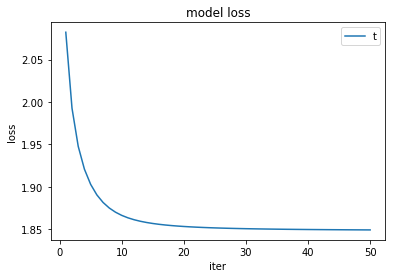

In [218]:
plt.plot(np.arange(1 , len(dnn.loss) + 1) , dnn.loss , label = "loss")
# plt.plot(np.arange(1 , len(slr.val_loss) + 1) , slr.val_loss , label = "test_loss")
plt.title("model loss")
plt.xlabel("iter")
plt.ylabel("loss")
plt.legend("train_loss")
plt.show()

In [219]:
dnn._predict(X_test)

array([7, 7, 7, ..., 7, 7, 7])

In [220]:
dnn.accuracy(X_test, y_test)

0.1028

In [272]:
class ActSigmoid:
    
    def forward(self, A):
        self.A = A
        return self.sigmoid(A)
    
    def backward(self, dZ):
        _sig = self.sigmoid(self.A)
        return dZ * (1 - _sig)*_sig
    
    def sigmoid(self, X):
        return 1 / (1 + np.exp(-X))

class ActTanh:
    
    def forward(self, A):
        self.A = A
        return np.tanh(A)
    
    def backward(self, dZ):
        return dZ * (1 - (np.tanh(self.A))**2)

class ActSoftmax:
    
    def forward(self, X):
        self.Z = np.exp(X) / np.sum(np.exp(X), axis=1).reshape(-1,1)
        return self.Z
    
    def backward(self, Y):
        self.loss = self.loss_func(Y)
        return self.Z - Y
    
    def loss_func(self, Y, Z=None):
        """
        y_true : (n_samples, n_output)
        z : (n_samples, n_output)
        """
        if Z is None:
            Z = self.Z
        return (-1)*np.average(np.sum(Y*np.log(Z), axis=1))

class ActReLU:
    def forward(self, A):
        self.A = A
        return np.clip(A, 0, None)
    
    def backward(self, dZ):
        return dZ * np.clip(np.sign(self.A), 0, None)

class ScratchConvNeuralNetrowkClassifier:
    
    def __init__(self, num_epoch=10, lr=0.01, batch_size=20, 
                 n_features=784, n_nodes1=400, n_nodes2=200, n_output=10, 
                 verbose=True, Activater=ActTanh, Optimizer=AdaGrad):
        self.num_epoch = num_epoch
        self.lr = lr
        self.verbose = verbose
        
        self.batch_size = batch_size # バッチサイズ
        self.n_features = n_features # 特徴量の数
        # self.n_nodes1 = n_nodes1 # 1層目のノード数 # self.conv1d_3.n_out になる
        self.n_nodes2 = n_nodes2 # 2層目のノード数
        self.n_output = n_output # 出力のクラス数（3層目のノード数）
        
        self.Activater = Activater
        if Activater == ActSigmoid or Activater == ActTanh:
            self.Initializer = XavierInitializer
        elif Activater == ActReLU:
            self.Initializer = HeInitializer
        else:
            print("活性化関数が不適切")
        self.Optimizer = Optimizer
    
    def fit(self, X, y, X_val=None, y_val=None):
        
        self.val_enable = False
        if X_val is not None:
            self.val_enable = True
        
        #optimizer = self.Optimizer(self.lr)
        self.conv1d_3 = Conv1d_3(filter_size=7, initializer=SimpleInitializer(0.01), optimizer=self.Optimizer(self.lr), n_in_channels=1, n_out_channels=1, pa=3, st=2)
        self.conv1d_3.n_out = N_out(X.shape[-1], self.conv1d_3.filter_size, self.conv1d_3.pa, self.conv1d_3.st)
        self.activation1 = self.Activater()
        self.FC2 = FC(1*self.conv1d_3.n_out, self.n_nodes2, self.Initializer(), self.Optimizer(self.lr))
        self.activation2 = self.Activater()
        self.FC3 = FC(self.n_nodes2, self.n_output, self.Initializer(), self.Optimizer(self.lr))
        self.activation3 = ActSoftmax()
        
        self.loss = []
        self.loss_epoch = [self.activation3.loss_func(y, self.forward_propagation(X))]
        for _ in range(self.num_epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            self.iter = len(get_mini_batch)
            for mini_X, mini_y in get_mini_batch:
                self.forward_propagation(mini_X)
                self.back_propagation(mini_X, mini_y)
                self.loss.append(self.activation3.loss)
            self.loss_epoch.append(self.activation3.loss_func(y, self.forward_propagation(X)))
        
        if self.verbose:
            self.learning_curve()
            print()
        
    def predict(self, X):
        return np.argmax(self.forward_propagation(X), axis=1)
    
    def forward_propagation(self, X):
        A1 = self.conv1d_3.forward(X)
        A1 = A1.reshape(A1.shape[0], A1.shape[-1])
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        return Z3
        
    def back_propagation(self, X, y_true):
        dA3 = self.activation3.backward(y_true) # 交差エントロピー誤差とソフトマックスを合わせている
        dZ2 = self.FC3.backward(dA3)
        dA2 = self.activation2.backward(dZ2)
        dZ1 = self.FC2.backward(dA2)
        dA1 = self.activation1.backward(dZ1)
        dA1 = dA1[:, np.newaxis]
        dZ0 = self.conv1d_3.backward(dA1) # dZ0は使用しない
    
    def learning_curve(self):
        plt.title("model loss")
        plt.xlabel("num_epoch")
        plt.ylabel("loss")
        plt.plot(np.arange(1, self.num_epoch*self.iter + 1), self.loss, label="train_loss")
        plt.plot(np.arange(0, self.num_epoch + 1)*self.iter, self.loss_epoch, label="epoch_loss")
        if self.val_enable:
            plt.plot(np.arange(1, self.num_epoch + 1), self.val_loss, label="val_loss")
        plt.legend()
        plt.show()
        return
    
    def accuracy(self , X , t):
        y_pred = self.predict(X)
        return np.sum(y_pred == t) / float(X.shape[0])

class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.X = X
        A = X@self.W + self.B
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        dZ = dA@self.W.T
        self.dB = np.sum(dA, axis=0)
        self.dW = self.X.T@dA
        self.optimizer.update(self)
        return dZ

class XavierInitializer:
    def W(self, n_nodes1, n_nodes2):
        self.sigma = np.sqrt(1 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B
    
class HeInitializer():
    def W(self, n_nodes1, n_nodes2):
        self.sigma = math.sqrt(2 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B

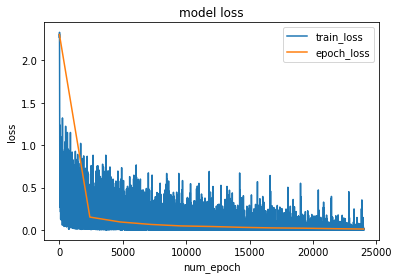

In [273]:
scratch_cnn = ScratchConvNeuralNetrowkClassifier(num_epoch=10, lr=0.01, batch_size=20, 
                                                  n_features=784, n_nodes1=400, n_nodes2=200, n_output=10, 
                                                  verbose=True, Optimizer=SGD)
scratch_cnn.fit(X_train, y_train)

In [274]:
scratch_cnn.accuracy(X_test, y_test)

0.9785